# **Import/Install Required libraries**

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install -q renderlab

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

from pathlib import Path
from collections import deque, namedtuple

import gymnasium as gym

from torch import Tensor
from typing import Tuple, List

**Set random seeds to reproduce**

In [ ]:
# set random seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

**Hyperparameters**

In [ ]:
# hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
LR = 1e-3
TARGET_UPDATE_FREQ = 30
EPISODES = 200
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 0.995
BUFFER_CAPACITY = 10000
SAVE_PATH = "dqn_model.pth"


##**Q network which takes in states and outputs logits for actions**

In [ ]:
# Deep Q network
class DQN(nn.Module):
  def __init__(self, n_obs: int, n_action: int, n_hidden: int) -> None:
    super().__init__()
    self.linear_block = nn.Sequential(
        nn.Linear(n_obs, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_action)
    )
  def forward(self, x: Tensor) -> Tensor:
    return self.linear_block(x)

##**Replay buffer to store experiences**

In [ ]:
Transition = namedtuple('transition', ['state', 'action', 'reward', 'next_state', 'done'])

# Replay buffer
class ReplayBuffer:
  def __init__(self, capacity: int) -> None:
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size: int) -> Tuple[Tensor]:
    transitions = random.sample(self.memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*transitions)
    return (torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32))

  def __len__(self):
    return len(self.memory)

##**DQN agent class: wraps around Q network and buffer and runs a training loop based on TD error**

In [ ]:
class DQNAgent:

  def __init__(self, n_obs: int, n_action: int) -> None:

    self.n_obs = n_obs
    self.n_action = n_action

    self.buffer = ReplayBuffer(capacity=BUFFER_CAPACITY)
    self.q_network = DQN(n_obs, n_action, n_hidden=128)
    self.target_network = DQN(n_obs, n_action, n_hidden=128)

    self.update_target_network()
    self.loss_fun = nn.MSELoss()
    self.optimizer = torch.optim.AdamW(self.q_network.parameters(), lr=LR)

    self.steps_done = 0

  def update_target_network(self) -> None:
    self.target_network.load_state_dict(self.q_network.state_dict())

  def select_action(self, state: List[float], epsilon: float) -> int:
    if random.random() < epsilon:
      return random.randint(0, self.n_action - 1)
    else:
      state = torch.tensor(state, dtype=torch.float32).unsqueeze(dim=0)
      with torch.no_grad():
        q_values = self.q_network(state)
      return q_values.argmax().item()

  def train_step(self) -> None:
    if len(self.buffer) < BATCH_SIZE:
      return

    states, actions, rewards, next_states, dones = self.buffer.sample(BATCH_SIZE)

    with torch.no_grad():
      max_next_q_values = self.target_network(next_states).max(dim=1)[0]
      targets = rewards + GAMMA * max_next_q_values * (1 - dones)

    current_q_values = self.q_network(states).gather(1, actions.unsqueeze(dim=1)).squeeze(dim=1)

    loss = self.loss_fun(current_q_values, targets)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.steps_done += 1
    if self.steps_done % TARGET_UPDATE_FREQ == 0:
      self.update_target_network()

  def save(self, path: Path) -> None:
    torch.save(self.q_network.state_dict(), path)

  def load(self, path: Path) -> None:
    if path.exists():
      self.q_network.load_state_dict(torch.load(path))
      self.update_target_network()
      print(f"Model loaded from {path}")
    else:
      print(f"No model found at {path}")

##**main loop: collect experiences and run training simulteneously**

In [ ]:
# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v3")
n_obs = env.observation_space.shape[0]
n_action = env.action_space.n

agent = DQNAgent(n_obs, n_action)
epsilon = EPS_START
reward_history = []

for episode in range(EPISODES):

  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:

    action = agent.select_action(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.buffer.push(state, action, reward, next_state, done)
    agent.train_step()
    state = next_state
    total_reward += reward

  epsilon = max(EPS_END, (EPS_START - (episode / (EPISODES * 0.5)) * (EPS_START - EPS_END)))
  reward_history.append(total_reward)

  if episode % 10 == 0:
    print(f"Episode: {episode + 1}, total rewards: {total_reward}, epsilon: {epsilon: .3f}")

agent.save(SAVE_PATH)
env.close()


<ipython-input-5-eebf93237085>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return (torch.tensor(states, dtype=torch.float32),


Episode: 1, total rewards: -173.65678390274246, epsilon:  1.000
Episode: 11, total rewards: -329.6756642776505, epsilon:  0.910
Episode: 21, total rewards: -100.96160354162524, epsilon:  0.820
Episode: 31, total rewards: -60.30706494091589, epsilon:  0.730
Episode: 41, total rewards: -33.159252446550155, epsilon:  0.640
Episode: 51, total rewards: -96.42906031314676, epsilon:  0.550
Episode: 61, total rewards: 39.13280098061671, epsilon:  0.460
Episode: 71, total rewards: -288.3946294274833, epsilon:  0.370
Episode: 81, total rewards: -545.5589094090938, epsilon:  0.280
Episode: 91, total rewards: -64.4603589387302, epsilon:  0.190
Episode: 101, total rewards: 194.8138856988556, epsilon:  0.100
Episode: 111, total rewards: 292.36953170747523, epsilon:  0.100
Episode: 121, total rewards: 257.25194127401977, epsilon:  0.100
Episode: 131, total rewards: 269.2330371379711, epsilon:  0.100
Episode: 141, total rewards: 278.32573279723215, epsilon:  0.100
Episode: 151, total rewards: 254.6474

**Plot reward history while training**

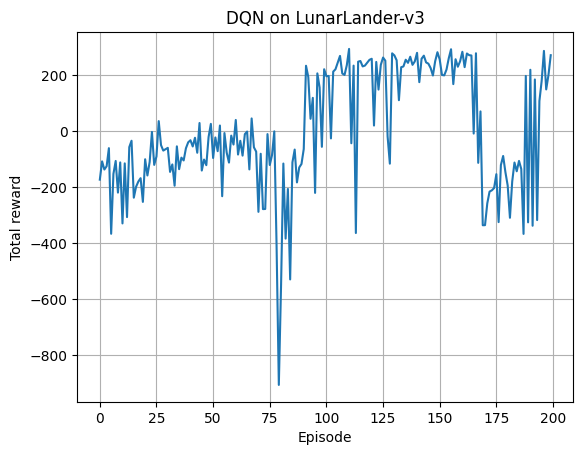

In [ ]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title(f"DQN on {env.spec.id}")
plt.grid()
plt.show()

##**Evaluate trained policy and render a video**

In [ ]:
import renderlab as rl

# eval_env = gym.make("CartPole-v1", render_mode="rgb_array")
eval_env = gym.make("LunarLander-v3", render_mode="rgb_array")
eval_env = rl.RenderFrame(eval_env, "./output")

agent.load(Path(SAVE_PATH))

eval_episodes = 1

for episode in range(eval_episodes):
  state = eval_env.reset()[0]
  done = False
  total_reward = 0

  # while not done:
  for _ in range(500):
      action = agent.select_action(state, epsilon=0.0)
      state, reward, done, _, _ = eval_env.step(action)
      total_reward += reward

  print(f"Eval episode: {episode + 1}, Total reward: {total_reward}")

eval_env.render()
eval_env.close()
eval_env.play()  # Play rendered frames directly in Colab

Model loaded from dqn_model.pth
Eval episode: 1, Total reward: 16471.586109325024
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
